In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import numpy as np
import pandas as pd
import catboost

from catboost import cv, Pool
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
catboost.__version__

'0.17.4'

In [3]:
np.__version__

'1.17.2'

In [4]:
days_from_start = {
    1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181,
    8: 212, 9: 243, 10: 273, 11: 304, 12: 334
}

days_in_month = {
    1: 31,  2: 28,  3: 31,  4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30,  10: 31, 11: 30, 12: 31
}

params =  {
    "random_seed": 17,
    "eval_metric": "AUC"
    
}

season_from_moth = {12: "winter", 1: "winter", 2: "winter",
                    3: "spring", 4: "spring", 5: "spring", 
                    6: "summer", 7: "summer", 8: "summer", 
                    9: "autumn", 10: "autumn", 11: "autumn"
                   }

weekend = {1: 0, 2: 0,  3: 0, 4: 0, 5: 0, 6: 1, 7: 1 }

In [5]:
def encode_and_cat(data):
    for name in encode_names:
        data[name] = pd.factorize(data[name])[0]
        
    for name in cat_names:
        data[name] = data[name].astype('category')    

In [ ]:
    data.DayofMonth = data.DayofMonth + data.DepTime // 2401
    data.DayOfWeek = data.DayOfWeek + data.DepTime // 2401
    data.Month = data.Month + data.DayofMonth // (data.days_in_m + 1)
    
    data.DepTime = data.DepTime % 2401
    data.DepTime = data.DepTime + (data.DepTime == 0)
    

In [40]:
cat_names = "Month DayofMonth DayOfWeek UniqueCarrier Origin Dest hour".split()
cat_names.extend("fligth".split())

encode_names = "UniqueCarrier Origin Dest fligth".split()

def clean_data(data):
    for name in ['Month', 'DayofMonth', 'DayOfWeek']:
        data[name] = data[name].str[2:].astype(int)
    
    data["days_in_m"] = data.Month.map(days_in_month)
    


    #8  -- add minutes as num
    data["minutes"] = data.DepTime % 100
    # -- 4
    data["hour"] = data.DepTime // 100
    
    data.loc[data['hour'] == 24, 'hour'] = 0
    data.loc[data['hour'] == 25, 'hour'] = 1
    
        
    # -- 1
    data["dep_t"] = data.hour  // 100 * 60 + data.DepTime % 100 # some accturacy on cv
    
    # -- 2
    data.Distance = np.power(np.log10(data.Distance), 2)
    # -- 3 (0.857, 0.752)
    data['sin_time'] = np.sin(2 * np.pi * data.dep_t / (24*60))
    data['cos_time'] = np.cos(2 * np.pi * data.dep_t / (24*60))    
    
    data.drop("dep_t", axis=1, inplace=True)
    
    # -- 5  add season (0.8516, 0.7519)
    # data["season"] = data.Month.map(season_from_moth)
    # -- 6 season as dummy 0.8483, 0.7517 
    # -- 7 add fligth (0.865, 0.7538)
    data["fligth"] = data.Origin + "_" + data.Dest
    # -- 9
    # data['daytime'] = pd.cut(data['hour'], bins=[1, 6, 12, 18, 24], include_lowest=True)
    
    # --- 10 change recalculate
    # --- 11 drop season and daytime --- beat baseline
    
    data.drop(["days_in_m"], axis=1, inplace=True)

In [17]:
df = pd.read_csv('../../data/flight_delays_train.csv')
y_train = df['dep_delayed_15min'].map({'Y': 1, 'N': 0})
df.drop("dep_delayed_15min", axis=1, inplace=True)
test_df = pd.read_csv('../../data/flight_delays_test.csv')
split = df.shape[0]

In [18]:
df.head(2)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834


In [31]:
full_df = pd.concat((df, test_df))

clean_data(full_df)
encode_and_cat(full_df)

X_valid, X_test = full_df[:split].values, full_df[split:].values

cat_i = np.where(full_df.dtypes == 'category')[0]
cat_i
full_df.shape
full_df.head(2)

array([ 0,  1,  2,  4,  5,  6,  9, 12], dtype=int64)

(200000, 13)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,minutes,hour,sin_time,cos_time,fligth
0,8,21,7,1934,0,0,0,8.205424,34,19,0.147809,0.989016,0
1,4,20,3,1548,1,1,1,8.533211,48,15,0.207912,0.978148,1


In [32]:
%%time

test_score = []
train_score = []

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

i = 0
for test_index, train_index in skf.split(X_valid, y_train):
    print("| ", end="")
    
    X_train_1, X_test_1 = X_valid[train_index, :], X_valid[test_index, :]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    
    
    ctb = CatBoostClassifier(random_seed=17,
                              silent=True
                             ).fit(X_train_1, y_train_1, cat_features=cat_i)
    
    test_score.append(
        roc_auc_score(y_test_1, ctb.predict_proba(X_test_1)[:, 1]))
    
    train_score.append(roc_auc_score(y_train_1, ctb.predict_proba(X_train_1)[:, 1]))
    
    i += 1
    print(i, end = " ")
    

 |  | 1
 | 2
 | 3
Wall time: 4min 32s


In [12]:
iter_ = [[0.828 , 0.7429],
       [0.8297, 0.7429],
       [0.8297, 0.7429],
       [0.8218, 0.7433],
       [0.857 , 0.752 ],
       [0.8516, 0.7519],
       [0.8483, 0.7517],
       [0.865 , 0.7538],
       [0.8769, 0.7577],
       [0.8647, 0.756 ],
       [0.8741, 0.7569],
       [0.8723, 0.7565],
       [0.8871, 0.7583]]

In [ ]:
iter_ = np.array(iter_)

In [33]:
iter_.append((round(np.mean(train_score), 4), round(np.mean(test_score), 4)))

In [44]:
iter_

array([[0.828 , 0.7429],
       [0.8297, 0.7429],
       [0.8297, 0.7429],
       [0.8218, 0.7433],
       [0.857 , 0.752 ],
       [0.8516, 0.7519],
       [0.8483, 0.7517],
       [0.865 , 0.7538],
       [0.8769, 0.7577],
       [0.8647, 0.756 ],
       [0.8741, 0.7569],
       [0.8723, 0.7565],
       [0.8871, 0.7583]])

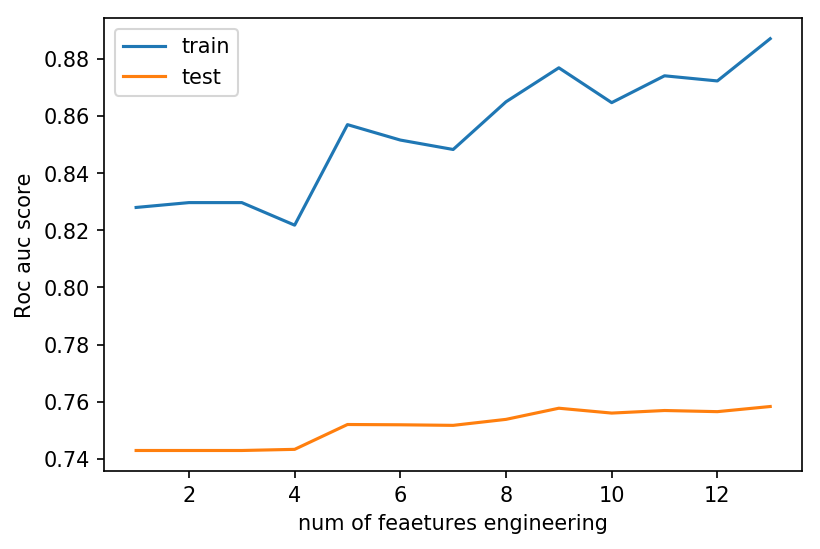

In [53]:
x = np.arange(1, len(iter_) + 1)
plt.figure(dpi=150)
plt.plot(x, iter_[:, 0], label="train");
plt.plot(x, iter_[:, 1], label="test");
plt.ylabel("Roc auc score");
plt.xlabel("num of feaеtures engineering");
plt.legend();

In [35]:
# drop daytime and season
print(round(np.mean(train_score), 4), " - train score")
print(round(np.mean(test_score), 4), " - test score")
print(*sorted(zip(ctb.get_feature_importance(), full_df.columns), reverse=True), sep="\n")

0.8871  - train score
0.7583  - test score
(29.46701447062555, 'hour')
(16.045687820949198, 'DepTime')
(8.331970646519023, 'UniqueCarrier')
(6.57683639781866, 'Month')
(6.176857661333528, 'Origin')
(6.073900120153994, 'fligth')
(5.9363282259019865, 'Dest')
(4.443706470866662, 'DayOfWeek')
(4.225422883994927, 'DayofMonth')
(4.159184695228634, 'Distance')
(3.1680133300508673, 'cos_time')
(2.8152070617581786, 'minutes')
(2.579870214798677, 'sin_time')


In [26]:
# change recalculate
print(round(np.mean(train_score), 4), " - train score")
print(round(np.mean(test_score), 4), " - test score")
print(*sorted(zip(ctb.get_feature_importance(), full_df.columns), reverse=True), sep="\n")

0.8723  - train score
0.7565  - test score
(21.03685917985345, 'hour')
(16.29549492559493, 'daytime')
(10.423194032307377, 'DepTime')
(7.658367060492322, 'UniqueCarrier')
(6.8852575109387075, 'fligth')
(5.750071078329226, 'Month')
(4.795076313613704, 'Origin')
(4.724916981037079, 'DayofMonth')
(4.628544555224909, 'Dest')
(4.518182793908016, 'DayOfWeek')
(3.920689924668831, 'Distance')
(3.6529998617908697, 'season')
(2.2108980434439793, 'sin_time')
(2.1795649988552848, 'minutes')
(1.3198827399414657, 'cos_time')


In [37]:
%%time
ctb.fit(X_valid, y_train,
        cat_features=cat_i);

Wall time: 2min 27s


In [38]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]


In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('../../data/sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('hour, minutes, sin_time, cos_time.csv')